# Slicing modelisation of 5G networks

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Part 1

### Exercise 1

Let $P(k)$ be the probability of having $k$ clients in a queue $M / M / S / S$.
As seen in class, this probability is equal to:
$$
P(k) = \frac{\frac{\rho^k}{k!}}{\sum_{j = 0}^S \frac{\rho^j}{j!}}.
$$

Thus, it is clear that $P(k)$ is defined by the following recurrence relation:

\begin{align}
P(k) &= \frac{\rho}{k} P(k - 1) \\
&= \frac{\rho^2}{k (k - 1)} P(k - 2) \\
&\vdots \\
&= \frac{\rho^k}{k!} P(0)
\end{align}

So, we have one degree of freedom defined by the value of $P(0)$.
Since $\sum_{k = 0}^S P(k) = 1$, the value of $P(0)$ is simply a normalizing constant, which makes sense when looking at the whole equation above.
Therefore, we can compute every $P(k)$ without factorials by simply using the recurrence relation and, after that, normalize all values such that their sum is equal to 1.
Moreover, to find the mean number of clients in the system, we can use the expectation formula, i.e.,
$$
\mu_N = \mathbb{E}[P(k)] = \sum_{k = 0}^S k P(k)
$$

In [2]:
def client_probs(rho, S):
    Pk = [1]
    
    for k in range(1, S + 1):
        prob = (rho / k) * Pk[-1]
        Pk.append(prob)

    Pk = np.array(Pk)
    return Pk / Pk.sum()

In [3]:
def mean_number_waiting_customers(arrival_rate, service_rate, nb_of_servers):
    rho = arrival_rate / service_rate
    S = nb_of_servers

    Pk = client_probs(rho, S)
    return np.dot(np.arange(S + 1), Pk)

### Exercise 2

In [4]:
def erlang_b(rho, S):
    if S == 0:
        return 1
        
    erlang_inv = 1 + S / (rho * erlang_b(rho, S - 1))
    return 1 / erlang_inv

In [5]:
S = 4
lamb = 6
mu = 12

rho = lamb / mu

# Sanity check
print(np.abs(erlang_b(rho, S) - client_probs(rho, S)[S]) < 1e-10)

True


In [6]:
print(f"{rho = }, {S = }")
print(f"Erl_B = {erlang_b(rho, S):.4f}")
print(f"mean clients = {mean_number_waiting_customers(lamb, mu, S):.4f}")

rho = 0.5, S = 4
Erl_B = 0.0016
mean clients = 0.4992


We notice that the mean number of clients is approximately equal to $\rho$. This makes sense because in a $M / M / \infty$, we can find the mean number as exactly $\rho$ as shown below:

\begin{align}
\lim_{S \to \infty} \mathbb{E}[P(k)] &= \lim_{S \to \infty} \sum_{k = 0}^S k P(k) \\
&= \lim_{S \to \infty} \sum_{k = 0}^S k \frac{\rho^k}{k!} P(0) \\
&= \lim_{S \to \infty} \rho P(0) \sum_{k = 1}^S \frac{\rho^{k - 1}}{(k - 1)!} \\
&= \rho \lim_{S \to \infty} P(0) \sum_{k = 0}^{S - 1} \frac{\rho^{k}}{k!} \\
&= \rho \lim_{S \to \infty} \frac{1}{\sum_{j = 0}^{S} \frac{\rho^{j}}{j!}} \sum_{k = 0}^{S - 1} \frac{\rho^{k}}{k!} \\
&= \rho.
\end{align}

Since the Erlang-B is very small ($10^{-3}$), our queue behaves like a $M / M / \infty$ because there is almost no blockage.

## Part 2

### Exercise 1

We have the following constraints in our problem:

\begin{align}
0 \leq S_1 + S_2 &\leq S && \text{($S$ is the total number of servers and cannot be surpassed)} \\
Q_1 &= S_1 && \text{(Type 1 clients do not stay in the buffer)} \\
Q_2 &= S_2 + B && \text{(Type 2 clients can be either in the buffer or on the servers)} \\
B &\geq 0 && \text{(The buffer is non-negative)} \\
B > 0 \implies S_1 + S_2 &= S && \text{(Having a positive buffer implies that all servers are full)}.
\end{align}

Let us prove $Q_1 + S_2 < S \implies B = 0$.

\begin{align}
(B > 0 \implies S_1 + S_2 = S) &\iff (S_1 + S_2 \neq S \implies B \leq 0) \\
&\iff (S_1 + S_2 < S \implies B = 0)
\end{align}

### Exercise 2

$Q_1$ is the number of type 1 clients in our system. Let us model it as a Markov process. Because type 1 clients do not wait, we can say that it is a queue without buffer. Moreover, since servers occupied by type 2 clients can be preempted by type 1 clients, we can model $Q_1$ as always having $S$ servers (they will either be occupied by other type 1 clients or available). Finally, the rate of arrival of type 1 clients is a Poisson process of parameter $\lambda_1$ and the duration of service is an exponential of parameter $\mu_1$. Thus, we have all the ingredients to model $Q_1$ as a Markov process of a queue $M / M / S / S$. In this model, we would have the following transitions:

\begin{align}
q \to q + 1& \quad \text{with rate $\lambda_1$ if $q < S$} \\
q \to q - 1& \quad \text{with rate $q \mu_1$ otherwise}.
\end{align}

If $q = S$, incoming type 1 clients are lost.

### Exercise 3

There are 4 possible transitions in the process $(Q_1, Q_2)$:

\begin{align}
(q_1, q_2) &\to (q_1 + 1, q_2) \quad \text{Arrival of type 1 client with rate $\lambda_1$} \\
(q_1, q_2) &\to (q_1 - 1, q_2) \quad \text{Departure of type 1 client with rate $q_1 \mu_1$} \\
(q_1, q_2) &\to (q_1, q_2 + 1) \quad \text{Arrival of type 2 client with rate $\lambda_2$} \\
(q_1, q_2) &\to (q_1, q_2 - 1) \quad \text{Departure of type 2 client with rate $\min\{q_2, S - q_1\} \mu_2$}.
\end{align}

The rate of depature of client of type 2 is
$$
\min\{\underbrace{\mathrm{Exp}(\mu_2), \dots, \mathrm{Exp}(\mu_2)}_{s_2}\} = \mathrm{Exp}(s_2 \mu_2),
$$
because the aggregate rate represents the first served type 2 client to leave the system. We know that $S - q_1$ is the number of free servers plus the number of servers occupied by type 2 clients, $s_2$. So, if $q_2 < S - q_1 \iff q_1 + q_2 < S$, then $B = 0$, i.e., $q_2 = s_2$. Otherwise, $B > 0$, so there is no free server and $s_2 = S - q_1$. Thus,

\begin{align}
s_2 &= \begin{cases}
q_2 & \text{if $q_2 < S - q_1$} \\
S - q_1 & \text{otherwise}
\end{cases} \\
&= \min\{q_2, S - q_1\}.
\end{align}

### Exercise 4

In [7]:
def sample_exp(lamb):
    U = np.random.rand()
    return - np.log(U) / lamb


def sample_class(p: np.array):
    if np.abs(np.sum(p) - 1) > 1e-10:
        p = p / p.sum()
        
    cum_probs = np.cumsum(p)
    U = np.random.rand()
    return np.argmax(U < cum_probs)

In [8]:
def markov(S, mu_1, mu_2, lambda_1, lambda_2, t_max):
    q_1, q_2 = 0, 0

    x = [(q_1, q_2)]
    T = [0]

    for _ in range(t_max):    
        arrival_1 = lambda_1
        arrival_2 = lambda_2
        departure_1 = q_1 * mu_1
        departure_2 = min(q_2, S - q_1) * mu_2
        
        p = np.array([arrival_1, arrival_2, departure_1, departure_2])
        epsilon = sample_exp(p.sum())

        event = sample_class(p)

        if event == 0:
            q_1 += 1
        elif event == 1:
            q_2 += 1
        elif event == 2:
            q_1 -= 1
        else:
            q_2 -= 1

        t = T[-1] + epsilon

        x.append((q_1, q_2))
        T.append(t)

    return np.array(x), np.array(T)

In [9]:
S = 10
mu_1 = 2
mu_2 = 1
lambda_1 = 4
lambda_2 = 3

t_max = 1_000_000

x, T = markov(S, mu_1, mu_2, lambda_1, lambda_2, t_max)

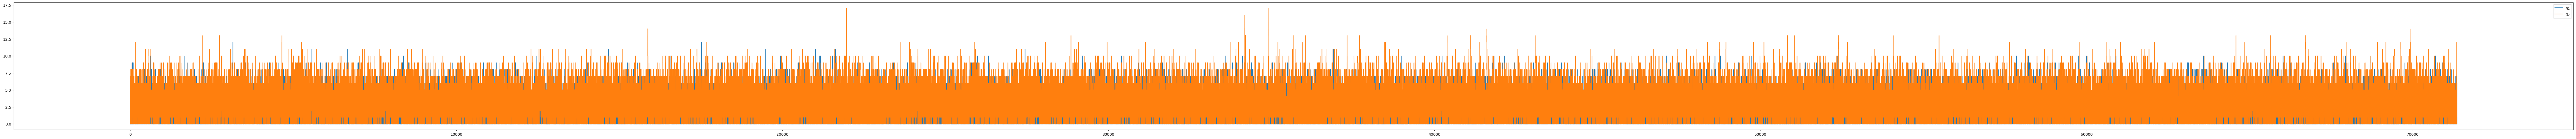

In [10]:
plt.figure(figsize=(120, 6))

plt.step(T, x[:, 0], where="post", label="$q_1$")
plt.step(T, x[:, 1], where="post", label="$q_2$")

plt.legend()
plt.show()

$$
\frac{1}{T} \int_0^T \mathbf{1}_{\{S\}}(x_1(s)) \, \mathrm{d}s \overset{T \to \infty}{\longrightarrow} \frac{\frac{\rho_1^S}{S!}}{\sum_{j = 0}^S \frac{\rho_1^j}{j!}}
$$

The left-hand side of the identity is the empirical simulated probability that the system has all servers occupied by type 1 clients, which is the blocking probability. In the long run, we can expect this time average to converge to the stationary theoretical distribution, which is given by the Erlang-B formula (right-hand side of identity). This limit holds since $Q_1$ behaves as a $M / M / S / S$ queue.

In [11]:
experimental_erlang = np.sum(x[:, 0] == S) / t_max
print(experimental_erlang)

rho_1 = lambda_1 / mu_1
theoretical_erlang = erlang_b(rho_1, S)
print(theoretical_erlang)

print(f"Difference: {np.abs(experimental_erlang - theoretical_erlang):.4f}")

7.6e-05
3.819016794126352e-05
Difference: 0.0000


## Part 3

### Exercise 1

S = 10, mu_1 = 2, mu_2 = 1, lambda_1 = 4, lambda_2 = 3
rho_2 + avg_1 < S? True


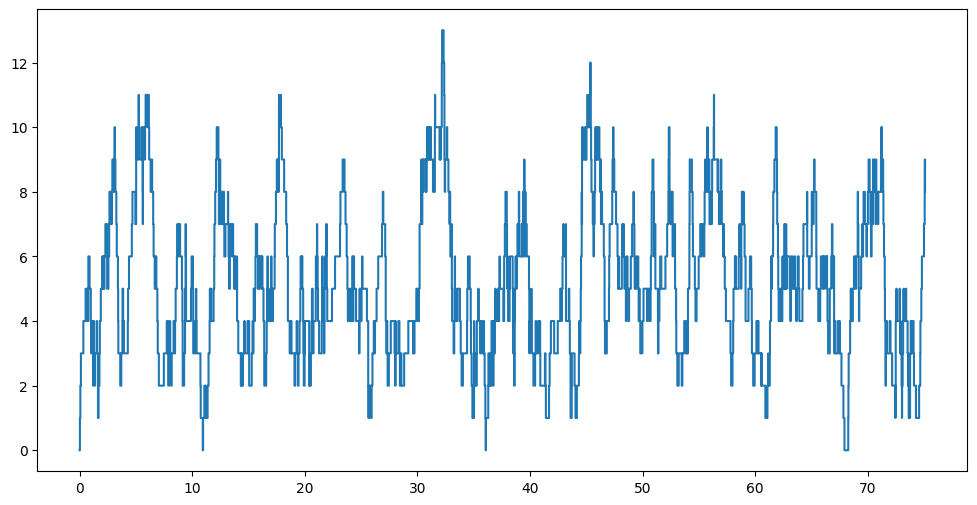

In [12]:
S = 10
mu_1 = 2
mu_2 = 1
lambda_1 = 4
lambda_2 = 3

print(f"{S = }, {mu_1 = }, {mu_2 = }, {lambda_1 = }, {lambda_2 = }")

mean_1 = mean_number_waiting_customers(lambda_1, mu_1, S)
rho_2 = lambda_2 / mu_2

print(f"rho_2 + avg_1 < S? {rho_2 + mean_1 < S}")

x, T = markov(S, mu_1, mu_2, lambda_1, lambda_2, 1_000)

plt.figure(figsize=(12, 6))
plt.step(T, x.sum(axis=1), where="post")
plt.show()

S = 10, mu_1 = 2, mu_2 = 1, lambda_1 = 12, lambda_2 = 9
rho_2 + avg_1 < S? False


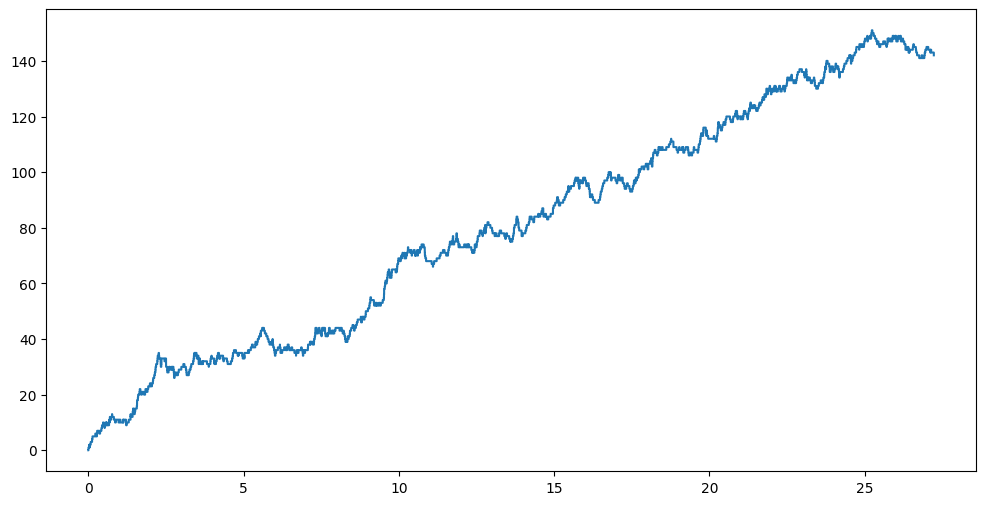

In [13]:
S = 10
mu_1 = 2
mu_2 = 1
lambda_1 = 12
lambda_2 = 9

print(f"{S = }, {mu_1 = }, {mu_2 = }, {lambda_1 = }, {lambda_2 = }")

mean_1 = mean_number_waiting_customers(lambda_1, mu_1, S)
rho_2 = lambda_2 / mu_2

print(f"rho_2 + avg_1 < S? {rho_2 + mean_1 < S}")

x, T = markov(S, mu_1, mu_2, lambda_1, lambda_2, 1_000)

plt.figure(figsize=(12, 6))
plt.step(T, x.sum(axis=1), where="post")
plt.show()

We can sweep $\lambda_2$ in a simulator and see that the type‑2 queue stays bounded below some value and blows up above it, so we could roughly locate the stability limit. But the true condition hides Erlang‑B sums that a simulation only shows as plain numbers, not the analytical series. Without doing the maths we would never guess that specific ratio; we would just curve‑fit an empirical threshold. So simulation is great for checking the formula, not for discovering it.

## Part 4

### Exercise 1

The balance equation is
$$
\pi Q = 0
$$

Since $Q$ is block tri-diagonal, we can rewrite it as
$$
x_{j - 1} \lambda_2 I + x_j B_j + x_{j + 1} A_{j + 1} = 0, \qquad j \geq 0.
$$
Here, we assume that $x_{-1} = 0$.
So, for $j \geq S$, let us prove that $x_j = x_S R^{j - S}$ solves the equation above.

But, before that, note that $A_j = A_S$ and $B_j = B_S$, for $j \geq S$.

\begin{align}
(x_S R^{j - 1 - S}) \lambda_2 I + (x_S R^{j - S}) B_j + (x_S R^{j + 1 - S}) A_{j + 1} &= (x_S R^{j - 1 - S}) (\lambda_2 I + R B_j + R^2 A_{j + 1}) \\
&= (x_S R^{j - 1 - S}) (\lambda_2 I + R B_S + R^2 A_{S + 1}) \\
&= (x_S R^{j - 1 - S}) (\lambda_2 I + R B_S + R^2 A_{S}) \\
&= 0
\end{align}

So, $R$ solves the balance equation.

### Exercise 2

\begin{align}
x_{S - 1} \lambda_2 I + x_S B_S + x_{S + 1} A_{S + 1} &= 0 \\
\lambda_2 x_{S - 1} &= - x_S B_S - x_S R A_{S + 1} \\
x_{S - 1} &= - x_S \left( \frac{B_S}{\lambda_2} + R \frac{A_{S}}{\lambda_2} \right) \\
x_{S - 1} &= - x_S ( \tilde{B}_S + R \tilde{A}_S)
\end{align}

### Exercise 3

Let us prove that $x_{j - 1} = x_j T_j$.
This will be done using induction.
The base case is proven in exercise 2.
Now, assume that $x_j = x_{j + 1} T_{j + 1}$. We want to show that this implies $x_{j - 1} = x_j T_j$.

\begin{align}
x_{j - 1} \lambda_2 I + x_j B_j + x_{j + 1} A_{j + 1} &= 0 \\
x_{j - 1} &= - x_j \tilde{B}_j - \underbrace{x_{j + 1}}_{x_j T_{j + 1}^{-1}} \tilde{A}_{j + 1} \\
x_{j - 1} &= - x_j \tilde{B}_j - x_j T_{j + 1}^{-1} \tilde{A}_{j + 1} \\
x_{j - 1} &= x_j \underbrace{(- \tilde{B}_j - T_{j + 1}^{-1} \tilde{A}_{j + 1})}_{T_j}.
\end{align}

So,
\begin{align}
T_S &= - \tilde{B}_S - R \tilde{A}_S \\
T_j &= - \tilde{B}_j - T_{j + 1}^{-1} \tilde{A}_{j + 1}, \qquad 0 \leq j < S
\end{align}

### Exercise 4

Using the balance equation for $j = 0$, we have
\begin{align}
x_0 (M - \lambda_2 I) + x_1 A_1 &= 0 \\
x_0 (M - \lambda_2 I) + x_0 T_0 A_1 &= 0 \\
x_0 ((M - \lambda_2 I) + T_0 A_1) &= 0 \\
x_0 ((\tilde{M} - I) + T_0 \tilde{A}_1) &= 0
\end{align}

### Exercise 5

To compute $x_S$, we can follow these steps:
1. Compute $R$ given the converging sequence;
2. Compute $T_S$ using $R$, $\tilde{A}_S$ and $\tilde{B}_S$;
3. Using the recurrence of $T_j$ found in exercise 3, we can compute $T_0, \ldots, T_S$;
4. With the equation from exercise 4, we can solve for $x_0$;
5. Applying the recurrence from exercise 3, and using $x_0$ and $T_0, \ldots T_S$, we can find $x_1, \ldots x_S$.

### Exercise 6